In [66]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import select
import cv2
import sys
import collections
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn import mixture
from skimage import feature
from skimage import feature as ft

NUMBER_OF_WORDS = 8
NUMBER_OF_KEYPOINTS = 20

importpath   = "../../../Dataset/"
testrainpath = ["Testing", "Training"]
namespath    = ["/Abed/", "/Daniel/", "/Jules/", "/Lea/", "/Patrick/"]
rescaledpath = "Rescaled"
croppedpath  = "Cropped"

meta_data = {0: 'Abed', 1: 'Daniel', 2: 'Jules', 3: 'Lea', 4: 'Patrick'}

def get_data(isCropped=True):
    '''
    Reads in data
    '''
    # Test train data
    X_train = []
    Y_train = []
    X_test  = []
    Y_test  = []

    # define both import paths
    testpath = importpath+testrainpath[0]
    trainpath= importpath+testrainpath[1]

    for i, npath in enumerate(namespath):

        if isCropped:
            testfolder = testpath + croppedpath + npath
            trainfolder= trainpath+ croppedpath + npath
        else:
            testfolder = testpath + rescaledpath + npath
            trainfolder= trainpath+ rescaledpath + npath

        for imgname in os.listdir(testfolder):

            img = cv2.imread(testfolder+imgname)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_test.append(img)
            Y_test.append(i)

        for imgname2 in os.listdir(trainfolder):

            img = cv2.imread(trainfolder+imgname2)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X_train.append(img)
            Y_train.append(i)

     # once the data is saved, shuffle it
      #X_train , Y_train = shuffle(X_train, Y_train)
      #X_test  , Y_test  = shuffle(X_test, Y_test)

    return np.asarray(X_train), np.asarray(Y_train), np.asarray(X_test), np.asarray(Y_test), meta_data


In [67]:
def sift(img, show_img):
    '''
    Calculates sift features for a given image
    '''
    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)
    
    points = []
    keypointsXY, descriptors = sift.compute(img, keypoints)
    for k in keypointsXY:
        points.append(k.pt)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # plot
    if(show_img):
        plt.figure(figsize=(10, 10))
        plt.subplot(121), plt.imshow(img)
        plt.title("Input Image"), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img_disp)
        plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
        plt.show()

    return points

def get_coordinates(img_rescaled, img_cropped):
    '''
    Get croppped image coordinates in original image (x,y in top left corner)
    '''
    img_rescaled = cv2.cvtColor(img_rescaled, cv2.COLOR_BGR2GRAY)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    w, h = img_cropped.shape[::-1]
    res = cv2.matchTemplate(img_rescaled, img_cropped, cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = top_left[0]
    y = top_left[1]
    return x, y


def make_patch(img,img_cropped, size, k, show_patch):
    '''
    Make patches from an image within the cropped image area, based on keypoint centers
    '''
    # get patch centers
    patch_centers = []
    for i in k:
        patch_centers.append(i)

    # extract patches
    patch_images = []
    patch_size = size
    count=0
    for center in patch_centers:
        patchXStart = int(center[0] - (patch_size / 2.))
        patchYStart = int(center[1] - (patch_size / 2.))
        if((center[0] + patch_size)>img_cropped.shape[1] or (center[0] - patch_size)<0 or (center[1] + patch_size)>img_cropped.shape[0] or (center[1] - patch_size)<0 ):
            count+=1
            x,y = get_coordinates(img, img_cropped)
            patchXStart += x
            patchYStart += y
            patch_images.append(img[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])
        else:
            patch_images.append(img_cropped[patchXStart:patchXStart + patch_size, patchYStart:patchYStart + patch_size])

     # Display
    if(show_patch):
        for i in range(0,3):
            plt.figure(figsize=(5, 5))
            plt.imshow(patch_images[i], cmap='gray')
            plt.title("Patch Number"+str(i)), plt.xticks([]), plt.yticks([])
            plt.show()

    return patch_images

def rgb2gray(im):
    '''
    Convert image to grayscale
    '''
    gray = im[:, :, 0] * 0.2989 + im[:, :, 1] * 0.5870 + im[:, :, 2] * 0.1140
    return gray

def hog_features(imgs, cells):
    '''
    Compute hog features for a given image
    '''
    train_x = []
    for data in imgs:
        gray = rgb2gray(data) / 255.0
        x = ft.hog(gray, orientations=9, pixels_per_cell=(2, 2),
                   cells_per_block=(cells, cells), feature_vector=True)
        train_x.append(x)
    return train_x

def get_hog(patches, cell_size):
    '''
    Compute hog features for each patch
    '''
    hog_patches = []
    for patch in patches:
        hog_ft = hog_features(patch, cell_size)
        hog_patches.append(hog_ft)
    return hog_patches

def makePatches(X_train, X_train_cropped, X_test, X_test_cropped, patch_size):
    '''
    Make patches of size patch_size for training and testing
    '''
    patches_train_list = []
    show_img = True
    show_patch = True
    for i in range(0, len(X_train_cropped)):
        cropped_img = X_train_cropped[i]
        original_img = X_train[i]
        kp = sift(cropped_img, show_img)
        patches_train = make_patch(img=original_img,img_cropped=cropped_img, size=patch_size, k=kp[:20], show_patch=show_patch)
        patches_train_list.append(patches_train)
        if(i%3 == 0):
            show_img = False
            show_patch = False     

    # Test Images

    patches_test_list = []
    for i in range(0, len(X_test_cropped)):  
        cropped_img_test = X_test_cropped[i]
        original_img_test = X_test[i]
        kp = sift(cropped_img_test, show_img)
        patches_test = make_patch(img=original_img_test,img_cropped=cropped_img_test, size=patch_size, k=kp[:20], show_patch=show_patch)
        patches_test_list.append(patches_test)
        
    return patches_train_list, patches_test_list

def makeModel(patches, n_words, cov_type='spherical'):
    '''
    Make GMM model for clustering descriptor features into group of owrds
    '''
    gmm_ = mixture.GaussianMixture(covariance_type=cov_type, n_components=n_words)
    gmm_.fit(patches)
    
    # Assign each feature to a group
    predictions = gmm_.predict(patches)
    
    # Get the count of each word
    counts = collections.Counter(predictions)
    
    # Normalize 
    for word in counts:
        counts[word] /= NUMBER_OF_WORDS
        return predictions, counts
    
def closestDistance(bag_of_words_test, bag_of_words_train):
    '''
    Find the closest matching feature descriptor training image for each testing image
    '''
    min_dist = 1e6
    closest_matching = []
    # Get closest matching training image bag of words
    for i in range(len(bag_of_words_test)):
        indx = i
        for j in range(len(bag_of_words_train)):
            temp_dist = np.linalg.norm(bag_of_words_test[i] - bag_of_words_train[j])
            if(temp_dist < min_dist):
                min_dist = temp_dist
                indx = j
        closest_matching.append(Y_train[indx])
        
    accuracy = np.zeros(2)
    for i in range(len(closest_matching)):
        if(Y_test[i] == closest_matching[i]):
            accuracy[0] += 1
        else:
            accuracy[1] += 1
    
    conf = confusion_matrix(Y_test, closest_matching)
    
    return accuracy, conf

def BagOfWords(h_train, h_test):
    '''
    Create bag of words using training and testing features
    '''
    # Make a model to predict each group of features for each train image
    bag_of_words_train = []
    counts_train = []
    for i in range(len(h_train)):
        words, count = makeModel(h_train[i], n_words=NUMBER_OF_WORDS)
        bag_of_words_train.append(words)
        counts_train.append(count)

    # Display the histograms for 3 training images
    for i in range(3):
        n_words = NUMBER_OF_WORDS
        kp = NUMBER_OF_KEYPOINTS
        plt.xticks(np.arange(kp))
        plt.xlabel('Word index')
        plt.ylabel('Normalized Occurence')
        plt.title('Normalized Histogram of Words for image '+str(i))
        normalized = np.zeros(n_words)
        for i,j in counts_train[i].items():
            normalized[i] = j/n_words
        plt.bar(range(n_words), normalized)
        plt.show()

    # Make a model to predict each group of features for each test image
    bag_of_words_test = []
    counts_test = []
    for img in h_test:
        words, count = makeModel(h_test[i], n_words=NUMBER_OF_WORDS)
        bag_of_words_test.append(words)
        counts_test.append(count)

    # Find closest matching
    accur = closestDistance(bag_of_words_test, bag_of_words_train)
    
    return accur

def getLBPFt(img, radius):
    '''
    Get Local Binary Pattern features for a given image
    '''
    features = []
    count = 0
    for patch in img:
        data = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
        lbp = feature.local_binary_pattern(data, 8*radius, radius, method="uniform")
        features.append(np.array(lbp).ravel())

    return features

def getLBP(images, radius):
    '''
    Get Local Binary Pattern features for a given image
    '''
    lbp = []
    for img in images:
        l_ft = getLBPFt(img, radius)
        lbp.append(l_ft)
    return lbp


# Read in Data 

In [68]:
# Load Cropped Data

cropped_data = get_data(isCropped=True)
X_train_cropped = cropped_data[0]
Y_train_cropped = cropped_data[1]
X_test_cropped = cropped_data[2]
Y_test_cropped = cropped_data[3]
metadata_cropped = cropped_data[4]

# Load Original Data
data = get_data(isCropped=False)
X_train = data[0]
Y_train = data[1]
X_test = data[2]
Y_test = data[3]
metadata = data[4]    

## 4.3.1 - HoG with varying Cell sizes 

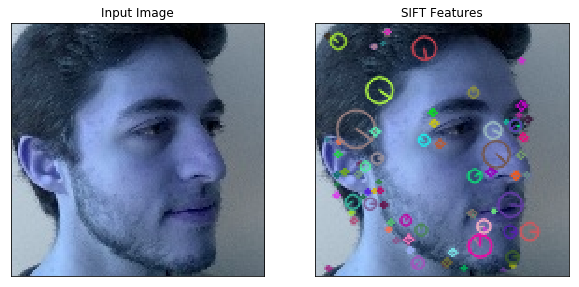

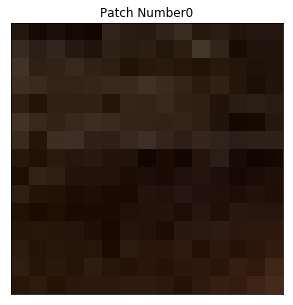

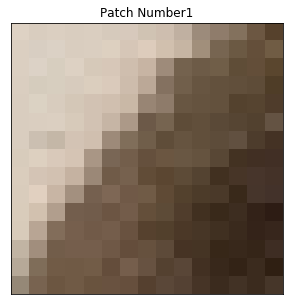

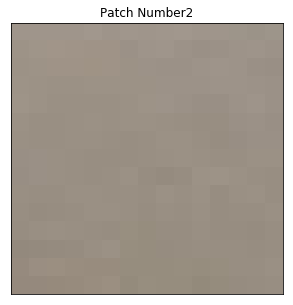

Bag of words w/ Cell Size 3


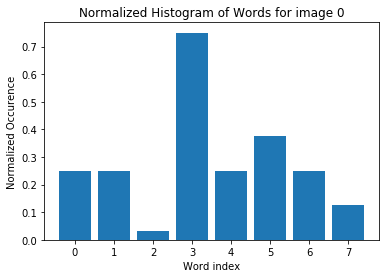

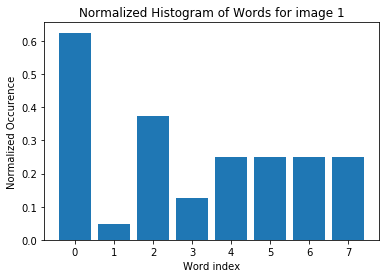

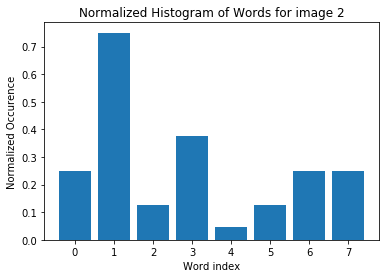

Bag of words w/ Cell Size 4


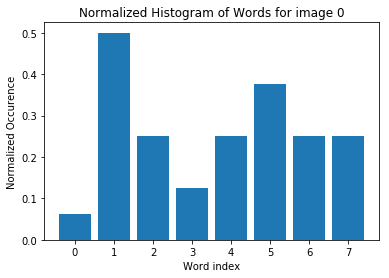

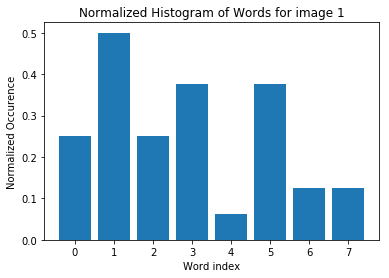

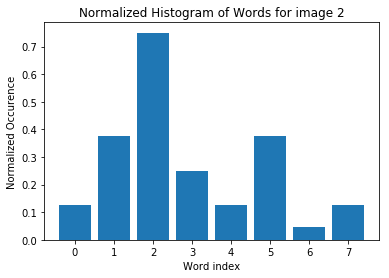

Bag of words w/ Cell Size 5


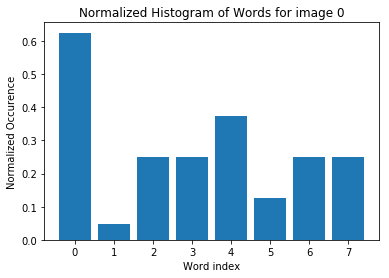

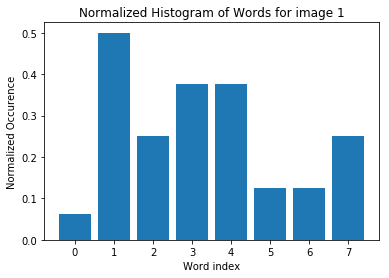

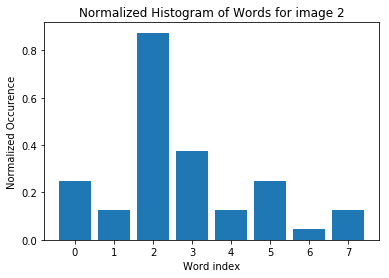

In [69]:
patches_train_list, patches_test_list = makePatches(X_train, X_train_cropped, X_test, X_test_cropped, patch_size=15)

h_3_train = get_hog(patches_train_list, 3)
h_3_test = get_hog(patches_test_list, 3)

h_4_train = get_hog(patches_train_list, 4)
h_4_test = get_hog(patches_test_list, 4)

h_5_train = get_hog(patches_train_list, 5)
h_5_test = get_hog(patches_test_list, 5)

print('Bag of words w/ Cell Size 3')
acc3, conf3 = BagOfWords(h_3_train, h_3_test)
print('Bag of words w/ Cell Size 4')
acc4, conf4 = BagOfWords(h_4_train, h_4_test)
print('Bag of words w/ Cell Size 5')
acc5, conf5 = BagOfWords(h_5_train, h_5_test)

accuracies = []
accuracies.append(acc3)
accuracies.append(acc4)
accuracies.append(acc5)

confusions = []
confusions.append(conf3)
confusions.append(conf4)
confusions.append(conf5)


Accuracy of Bag of words w/ Cell Size3 80.0%


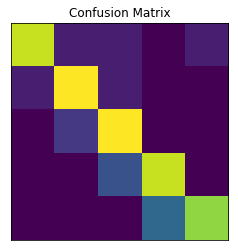

Accuracy of Bag of words w/ Cell Size4 77.14285714285715%


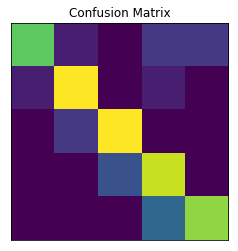

Accuracy of Bag of words w/ Cell Size5 80.0%


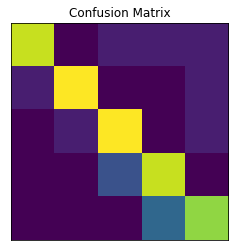

In [70]:
cell_size = [3, 4, 5]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    print('Accuracy of Bag of words w/ Cell Size' +str(cell_size[i])+' ' +str(acc*100) +'%' )
    plt.figure()
    plt.imshow(confusions[i])
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()

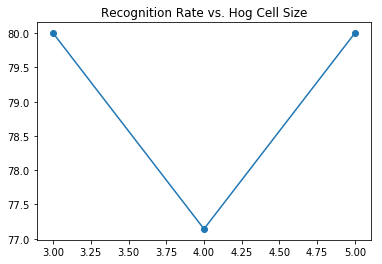

In [71]:
y = []
cell_size = [3, 4, 5]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    acc = acc*100
    y.append(acc)

x = [3, 4, 5]

plt.title("Recognition Rate vs. Hog Cell Size")
plt.scatter(x, y)
plt.plot(x,y)
plt.show()

## 4.3.1 - LpB with varying radius sizes 

Bag of words w/ radius 2


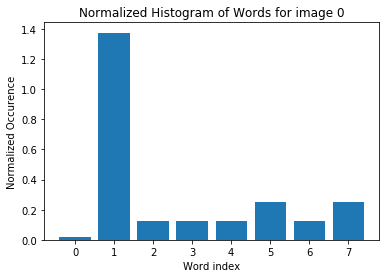

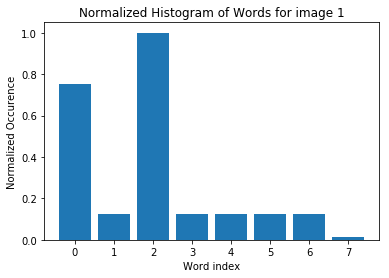

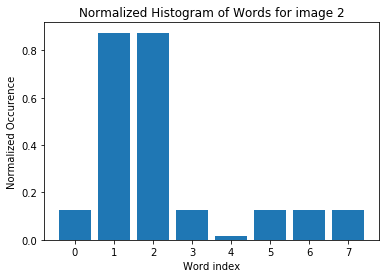

Bag of words w/ radius 7


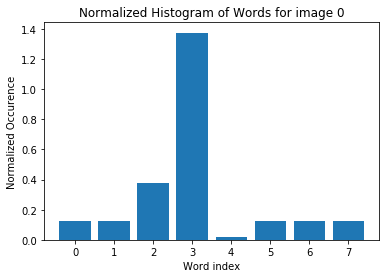

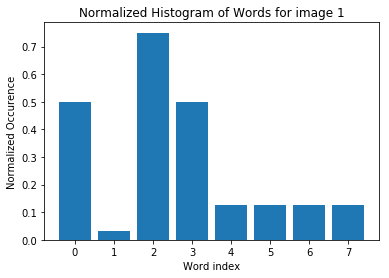

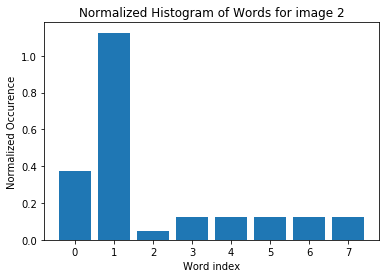

Bag of words w/ radius 12


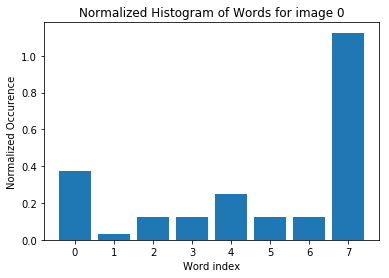

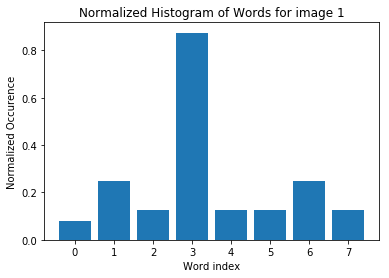

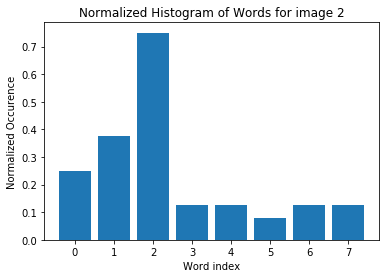

In [55]:
lbp_2_train = getLBP(patches_train_list, 2)
lbp_2_test = getLBP(patches_test_list, 2)

lbp_7_train = getLBP(patches_train_list, 7)
lbp_7_test = getLBP(patches_test_list, 7)

lbp_12_train = getLBP(patches_train_list, 12)
lbp_12_test = getLBP(patches_test_list, 12)


print('Bag of words w/ radius 2')
acc2, conf2 = BagOfWords(lbp_2_train, lbp_2_test)
print('Bag of words w/ radius 7')
acc7, conf7 = BagOfWords(lbp_7_train, lbp_7_test)
print('Bag of words w/ radius 12')
acc12, conf12 = BagOfWords(lbp_12_train, lbp_12_test)

accuracies = []
accuracies.append(acc2)
accuracies.append(acc7)
accuracies.append(acc12)

confusions = []
confusions.append(conf2)
confusions.append(conf7)
confusions.append(conf12)

Bag of words with radius:2, Accuracy: 82.85714285714286%


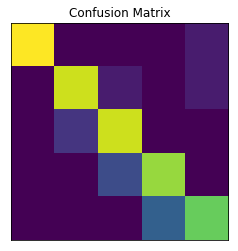

Bag of words with radius:7, Accuracy: 84.28571428571429%


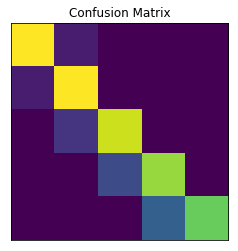

Bag of words with radius:12, Accuracy: 80.0%


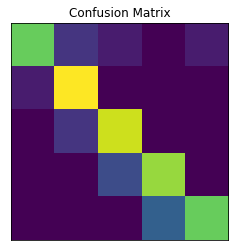

In [56]:
radius_size = [2, 7, 12]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    print('Bag of words with radius:' +str(radius_size[i])+', Accuracy: ' +str(acc*100) +'%' )
    plt.figure()
    plt.imshow(confusions[i])
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()

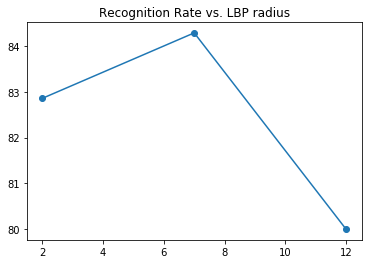

In [57]:
y = []
radius = [2, 7, 12]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    acc = acc*100
    y.append(acc)

plt.title("Recognition Rate vs. LBP radius")
plt.scatter(radius, y)
plt.plot(radius,y)
plt.show()

## 4.3.2 - Varying Patch sizes 

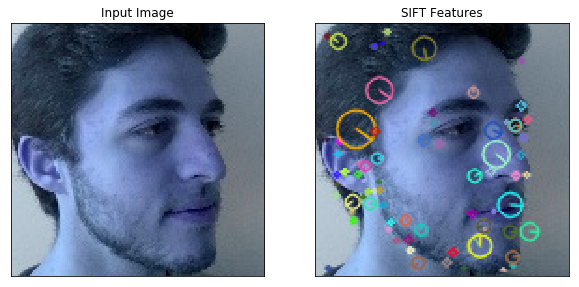

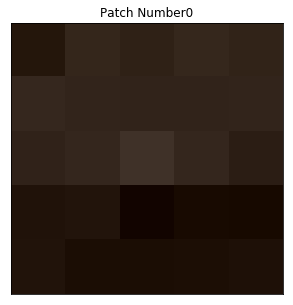

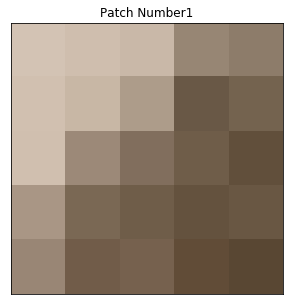

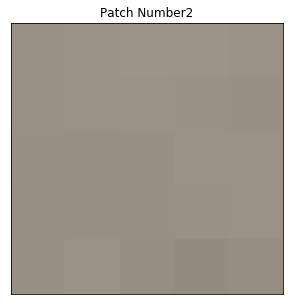

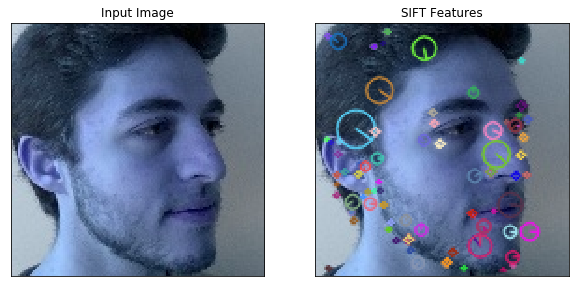

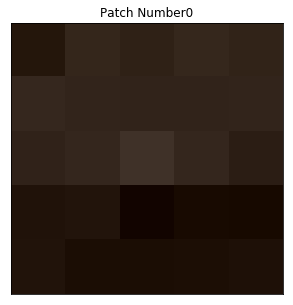

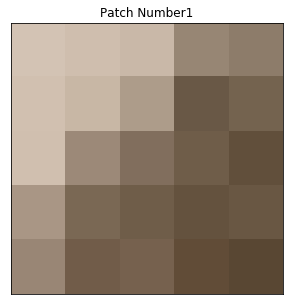

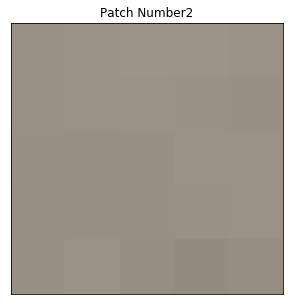

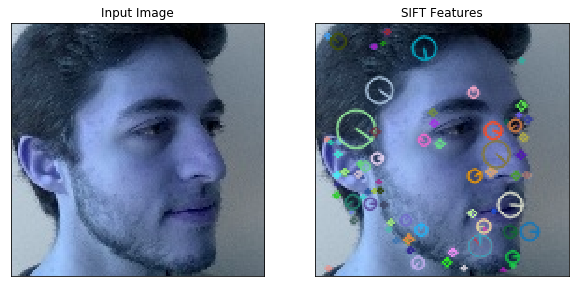

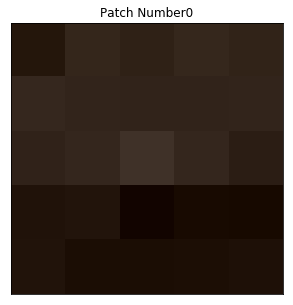

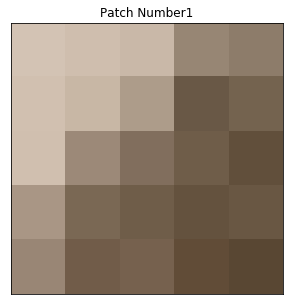

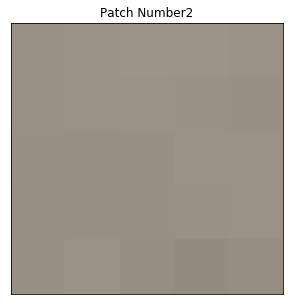

In [58]:


patches_5 = makePatches(X_train, X_train_cropped, X_test, X_test_cropped, patch_size=5)
patches_10 = makePatches(X_train, X_train_cropped, X_test, X_test_cropped, patch_size=5)
patches_15 = makePatches(X_train, X_train_cropped, X_test, X_test_cropped, patch_size=5)

patches = []
patches.append(patches_5)
patches.append(patches_10)
patches.append(patches_15)

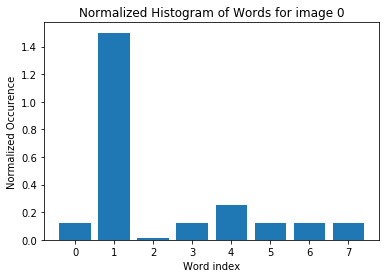

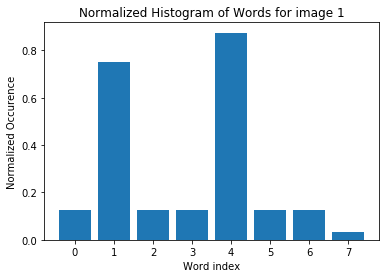

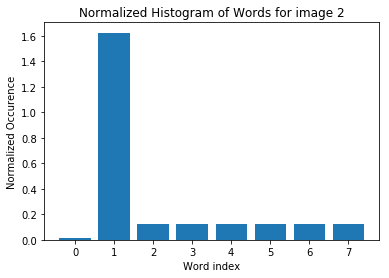

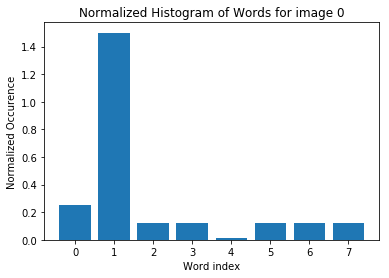

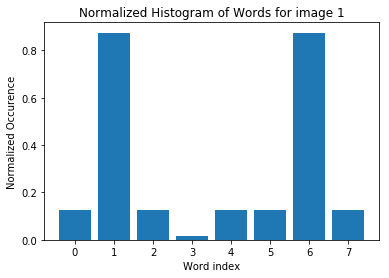

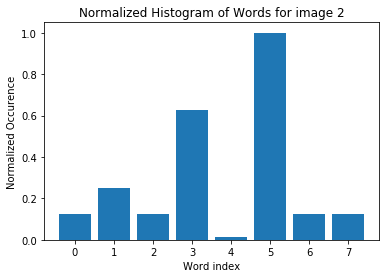

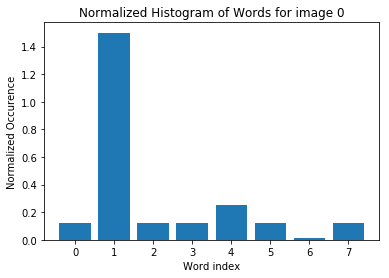

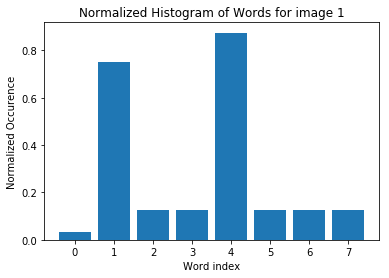

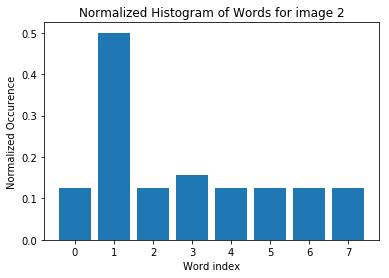

In [61]:
confusions = []
accuracies = []
for i in range(len(patches)):
    lbp_train = getLBP(patches_train_list, 2)
    lbp_test = getLBP(patches_test_list, 2)
    acc, conf = BagOfWords(lbp_train, lbp_test)
    accuracies.append(acc)
    confusions.append(conf)

Accuracy of Bag of words w/ Cell Size5 80.0%


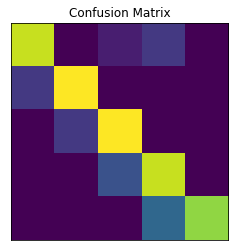

Accuracy of Bag of words w/ Cell Size10 82.85714285714286%


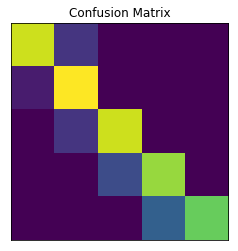

Accuracy of Bag of words w/ Cell Size15 82.85714285714286%


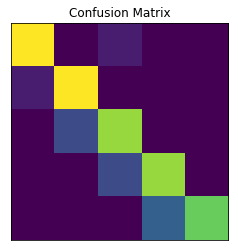

In [62]:
patch_size = [5, 10, 15]
for i in range(len(accuracies)):
    acc = accuracies[i][0] / (accuracies[i][0]+accuracies[i][1])
    print('Accuracy of Bag of words w/ Cell Size' +str(patch_size[i])+' ' +str(acc*100) +'%' )
    plt.figure()
    plt.imshow(confusions[i])
    plt.title("Confusion Matrix"), plt.xticks([]), plt.yticks([])
    plt.show()

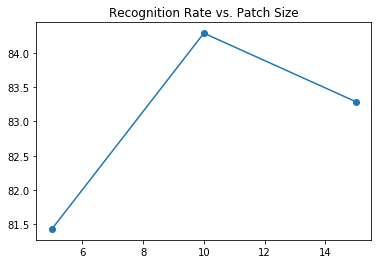

In [60]:
y = [81.43, 84.29, 83.29]
radius = [5, 10, 15]
plt.title("Recognition Rate vs. Patch Size")
plt.scatter(radius, y)
plt.plot(radius,y)
plt.show()